In [1]:
pip install tensorflow_io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.2 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.33.0
    Uninstalling tensorflow-io-gcs-filesystem-0.33.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.33.0


In [2]:
from tensorflow import keras
from tensorflow import math

In [3]:
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import gc
import copy
import random

In [4]:
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb
import tensorflow_io as tfio
from tensorflow.keras import datasets, layers, models, Model, utils, losses

In [5]:
#import psutil
#import time


#memory_usage = psutil.virtual_memory()
#print(f"Memory Usage: {memory_usage.percent}%")
#print(memory_usage)


## Load Data

loading on local host

In [6]:
#images_lab = np.load("checkpoint/1001_LAB.npy")
#color_blots = np.load("checkpoint/color_blots.npy")

Loading data in colab

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#del images_train
#del images_train_ab
#del images_test
#del images_test_ab
#gc.collect()

In [9]:
images_lab = np.load("drive/My Drive/deep_learning_projects/LAB/1001_LAB1_3.npy")
color_blots = np.load("drive/My Drive/deep_learning_projects/color_blots/color_blots1_3.npy")

In [10]:
i = 2000

In [11]:
images_lab = images_lab[i-1000:i,:,:,:]
color_blots = color_blots[i-1000:i,:,:,:]

In [12]:
full = np.concatenate([images_lab,color_blots], axis = 3)

In [13]:
del images_lab, color_blots
gc.collect()

11

In [14]:
full.shape

(1000, 512, 256, 6)

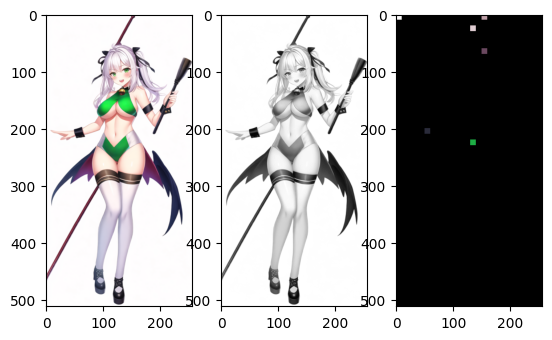

In [15]:
image_idx = 65
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
img = lab2rgb(full[image_idx,:,:,0:3])
ax1.imshow(img)
ax2.imshow(full[image_idx,:,:,0],cmap = "gray")
ax3.imshow(full[image_idx,:,:,3:6].astype(np.uint8))

# Normalisation

In [16]:
full = full.astype(np.float16)

In [17]:
full[:,:,:,0] = full[:,:,:,0]/100
full[:,:,:,1:3] = full[:,:,:,1:3]/127
full[:,:,:,3:6] = full[:,:,:,3:6]/127

In [18]:
#using half of data ...train 700-1400 next round and for test 1700-1850
images_train = full[0:700,:,:,(0,3,4,5)]
images_train_ab = full[0:700,:,:,1:3]
images_test = full[750:900,:,:,(0,3,4,5)]
images_test_ab = full[750:900,:,:,1:3]


In [19]:
#images_val_ab = full[i-300:i-150,:,:,1:3]
#images_val = full[i-300:i-150,:,:,(0,3,4,5)]

In [20]:
print(images_train.shape)
print(images_train_ab.shape)
print(images_test.shape)
print(images_test_ab.shape)
#print(images_val.shape)
#print(images_val_ab.shape)

(700, 512, 256, 4)
(700, 512, 256, 2)
(150, 512, 256, 4)
(150, 512, 256, 2)


In [21]:
#import random
#Generate 5 random numbers between 10 and 30
#randomlist = random.sample(range(0, 700), 15)

In [22]:
#1. Loading 1400-1700
#2. Loading 2700-2850
#random_data = np.load("drive/My Drive/deep_learning_projects/random_data/val_images.npy")
#random_data = np.concatenate([random_data,full[randomlist,:,:,:]],axis = 0)
#np.save("drive/My Drive/deep_learning_projects/random_data/val_images.npy",random_data)

In [23]:
#old_val = np.load("drive/My Drive/deep_learning_projects/test_data/val_images.npy")
#old_val_ab = np.load("drive/My Drive/deep_learning_projects/test_data/val_images_ab.npy")
#np.save("drive/My Drive/deep_learning_projects/test_data/val_images.npy",np.concatenate([old_val,images_val],axis = 0))
#np.save("drive/My Drive/deep_learning_projects/test_data/val_images_ab.npy",np.concatenate([old_val_ab,images_val_ab],axis = 0))

In [24]:
#print(images_train[1,:,:,:])

In [25]:
del full#, images_val, images_val_ab
gc.collect()

40

## Recompiling the model

In [26]:
@tf.keras.utils.register_keras_serializable()
@keras.saving.register_keras_serializable()
class Custom_Loss(tf.keras.losses.Loss):
    def __init__(self, reduction=tf.keras.losses.Reduction.AUTO, name=None):
        super().__init__(reduction=reduction, name=name)
    def call(self, y_true, y_pred):
      coeff = 10 # will be converted to x/1000
      y, idx = tf.raw_ops.UniqueV2(x = tf.reshape(tf.math.floor(y_pred), (-1,2)), axis = [0])
      count_pred = tf.size(y)
      count_pred = tf.cast(count_pred, tf.float16)/1000
      count_pred =  coeff * count_pred
      mae = tf.math.reduce_mean(tf.math.abs(tf.math.subtract(y_true, y_pred)))
      mae = tf.cast(mae, tf.float16)
      loss = mae + count_pred
      return loss

In [27]:
loaded_model = tf.keras.models.load_model('drive/My Drive/deep_learning_projects/models/unet_blot_nl_1000.keras')

In [28]:
loaded_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.002),
             loss= Custom_Loss() , metrics= 'mae')  # ['mae', Custom_Loss_Metric])

In [29]:
cp_callback = tf.keras.callbacks.EarlyStopping(
                                                monitor='val_loss',
                                                min_delta=0.001,
                                                patience=4,
                                                verbose=1,
                                                mode='auto',
                                                baseline=None,
                                                restore_best_weights=True,
                                                start_from_epoch=15
                                                )

In [ ]:
gc.collect()
results = loaded_model.fit(images_train,
                            images_train_ab,
                            batch_size=4,
                            epochs=50,
                            validation_data=(images_test, images_test_ab),
                            callbacks = [cp_callback],
                            verbose=1)

Epoch 1/50
175/175 [==============================] - 68s 250ms/step - loss: 0.0665 - mae: 0.0298 - val_loss: 0.0495 - val_mae: 0.0295
Epoch 2/50
175/175 [==============================] - 38s 219ms/step - loss: 0.0881 - mae: 0.0300 - val_loss: 0.0689 - val_mae: 0.0294
Epoch 3/50
175/175 [==============================] - 38s 219ms/step - loss: 0.0514 - mae: 0.0299 - val_loss: 0.0494 - val_mae: 0.0294
Epoch 4/50
175/175 [==============================] - 39s 221ms/step - loss: 0.0548 - mae: 0.0298 - val_loss: 0.0500 - val_mae: 0.0295
Epoch 5/50
175/175 [==============================] - 39s 222ms/step - loss: 0.0563 - mae: 0.0298 - val_loss: 0.0495 - val_mae: 0.0295
Epoch 6/50
175/175 [==============================] - 39s 222ms/step - loss: 0.0498 - mae: 0.0298 - val_loss: 0.0495 - val_mae: 0.0295
Epoch 7/50
175/175 [==============================] - 41s 237ms/step - loss: 0.0498 - mae: 0.0298 - val_loss: 0.0495 - val_mae: 0.0295
Epoch 8/50
175/175 [==============================] - 4

In [ ]:
loaded_model.save('drive/My Drive/deep_learning_projects/models/unet_blot_nl_2000.keras')

## Model Evaluation

In [ ]:
#images_val = np.load("drive/My Drive/deep_learning_projects/test_data/val_images.npy")
#images_val_ab = np.load("drive/My Drive/deep_learning_projects/test_data/val_images_ab.npy")

In [ ]:
full[:,:,:,0] = full[:,:,:,0]/100
full[:,:,:,1:3] = full[:,:,:,1:3]/127
full[:,:,:,3:6] = full[:,:,:,3:6]/255

In [ ]:
images_train = full[:,:,:,(0,3,4,5)].astype(np.float16)
images_train_ab = full[:,:,:,1:3].astype(np.float16)

In [ ]:
color_blots = full[:,:,:,(3,4,5)]*255

In [ ]:
del full
gc.collect()

40

In [ ]:
loaded_model = tf.keras.models.load_model('drive/My Drive/deep_learning_projects/models/unet_blot_6000nl.keras')

In [ ]:
#scaled images for model6000nl - float16
#loaded_model.evaluate(images_train, images_train_ab)

In [ ]:
gc.collect()
pred = loaded_model.predict(images_test)
print(pred.shape)

5/5 [==============================] - 21s 2s/step
(150, 512, 256, 2)


In [ ]:
gc.collect()
pred[:,:,:,0:2] = pred[:,:,:,0:2]*127

input_image = np.concatenate([images_test[:,:,:,0:1]*100,images_test_ab*127],axis = 3)


In [ ]:
output_image = np.concatenate([images_test[:,:,:,0:1]*100,pred],axis = 3)

In [ ]:
color_blots = images_test[:,:,:,1:4]*255

In [ ]:
#np.max(color_blots[index,:,:,0])

254.0

Text(0.5, 1.0, 'Input color values by user')

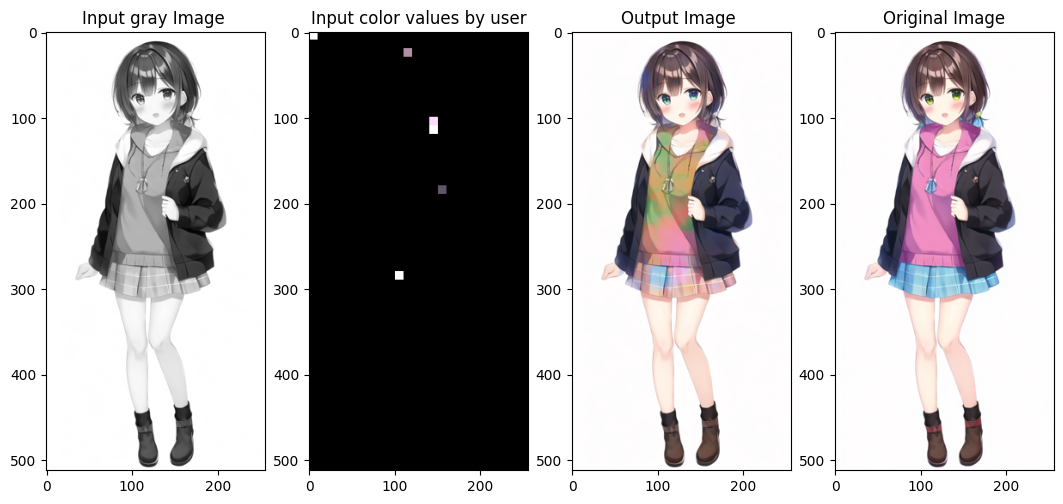

In [ ]:
# Results of Validation Dataset
index = 135
fig, arr = plt.subplots(1, 4, figsize=(13, 13))
arr[3].imshow(lab2rgb(input_image[index,:,:,:]))
arr[3].set_title('Original Image')
arr[2].imshow(lab2rgb(output_image[index,:,:,:]))
arr[2].set_title('Output Image ')
arr[0].imshow(input_image[index,:,:,0:1],cmap = "gray")
arr[0].set_title('Input gray Image ')
arr[1].imshow(color_blots[index,:,:,:].astype(int))
arr[1].set_title('Input color values by user')


In [ ]:
def sample_batch(data, bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return idxs
def sample_images(data, gray, nrow, epoch):
    idx = sample_batch(gray, bsize=nrow)
    gray_batch = gray[idx]
    color_batch = data[idx]
    images = model.predict(gray_batch)
    return np.array([images, gray_batch, color_batch])

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'Validation loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["mae"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_mae"], color='b', label = 'Validation accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()